## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import copy

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import music as music

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "Weights")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights

MODEL_PATH_NOTE = os.path.join(MODEL_DIR,"11072021notev6-Good\mask_rcnn_notev6_0059.h5")
#MODEL_PATH_STAFF = os.path.join(MODEL_DIR,"09102021-G\mask_rcnn_music_0088.h5")
MODEL_PATH_STAFF = os.path.join(MODEL_DIR,"11292021music\mask_rcnn_music_0095.h5")
MODEL_PATH_NOTERELOCATE = os.path.join(MODEL_DIR,"mask_rcnn_notes_0058.h5")

Using TensorFlow backend.


## Configurations

In [5]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset

configStaff = music.MusicConfig()
configNote = configStaff
COCO_DIR = "path to COCO dataset"  # TODO: enter value here

In [6]:
# Override the training configurations with a few
# changes for inferencing.

#c = ['G4','A4','B4','C3','D3','E3','F3','G3','A3','B3','C2','D2','E2','F2','G2','A2','B2','C','D','E','F','G']
c = ['note']
class InferenceConfigStaff(configStaff.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2
    DETECTION_MIN_CONFIDENCE = 0.5
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    DETECTION_MAX_INSTANCES = 1000
    #(32, 64, 128, 256, 512)

class InferenceConfigNote(configNote.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = len(c) + 1
    DETECTION_MIN_CONFIDENCE = 0.6
    DETECTION_MAX_INSTANCES = 1000
    RPN_ANCHOR_SCALES = (3, 12, 32, 64, 128)
    #(32, 64, 128, 256, 512)
    
class InferenceConfigNoterelocate(configNote.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = len(c) + 1
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_MAX_INSTANCES = 1000
    RPN_ANCHOR_SCALES = (3, 12, 32, 64, 128)
    #(32, 64, 128, 256, 512)

configStaff = InferenceConfigStaff()
configNote = InferenceConfigNote()
configNoteRelocate = InferenceConfigNoterelocate()

print("Staff")
configStaff.display()

print("Note")
configNote.display()

print("Note Location")
configNoteRelocate.display()

Staff

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1000
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE  

## Notebook Preferences

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [9]:
# Build validation dataset of note
#c = ['A','B','C','D','E','F','G','notes','SHP','TrC','BC','QR']
music.PROJECT_NAME = 'notev7'
datasetNote = music.MusicDataset()
datasetNote.load_music("D:\AI\MusicNotes\dataNotev1",'val',c)
datasetNote.prepare()

#Build validation dataset of staff
music.PROJECT_NAME = 'music'
datasetStaff = music.MusicDataset()
datasetStaff.load_music("D:\AI\MusicNotes\dataNotev1",'val',['staff'])
datasetStaff.prepare()

music.PROJECT_NAME = 'notes'
datasetNoteRelocate = music.MusicDataset()
datasetNoteRelocate.load_music("D:\AI\MusicNotes\dataNotev2",'val',['note'])
datasetNoteRelocate.prepare()


print("Images: {}\nClasses: {}".format(len(datasetNote.image_ids), datasetNote.class_names))
print("Images: {}\nClasses: {}".format(len(datasetStaff.image_ids), datasetStaff.class_names))
print("Images: {}\nClasses: {}".format(len(datasetNoteRelocate.image_ids), datasetNoteRelocate.class_names))



Images: 5
Classes: ['BG', 'note']
Images: 7
Classes: ['BG', 'note']
Images: 74
Classes: ['BG', 'note']


## Load Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    modelNote = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=configNote)
    
    modelStaff = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=configStaff)
    
    modelNoteRelocate = modellib.MaskRCNN(mode="inference", model_dir = MODEL_DIR,
                              config=configNoteRelocate)

# Set weights file path

weights_path_staff = MODEL_PATH_STAFF
weights_path_note = MODEL_PATH_NOTE
weights_path_noterelocate = MODEL_PATH_NOTERELOCATE

# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path_staff)
print("Loading weights ", weights_path_note)
print("Loading weights ", weights_path_noterelocate)

modelNote.load_weights(weights_path_note, by_name=True)
modelStaff.load_weights(weights_path_staff, by_name=True)
modelNoteRelocate.load_weights(weights_path_noterelocate,by_name =True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  D:\AI\MusicNotes\Weights\11292021music\mask_rcnn_music_0095.h5
Loading weights  D:\AI\MusicNotes\Weights\11072021notev6-Good\mask_rcnn_notev6_0059.h5
Loading weights  D:\AI\MusicNotes\Weights\mask_rcnn_notes_0058.h5








## Run Detection

image ID: music.sample (1).png (1) None
Processing 1 images
image                    shape: (1100, 850, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1100.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (0,)                  min:             max:             int32
gt_bbox                  shape: (0, 4)                min:             max:             int32
gt_mask                  shape: (0, 233, 0)           min:             max:             float64


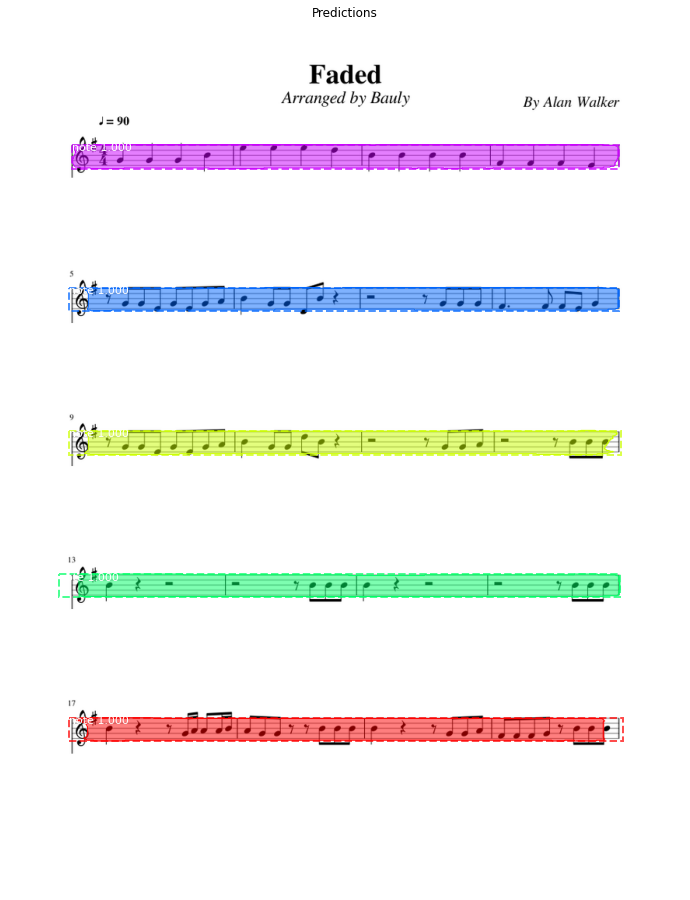

In [119]:
image_id = random.choice(datasetStaff.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(datasetStaff, configStaff, image_id, use_mini_mask=False)
info = datasetStaff.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       datasetStaff.image_reference(image_id)))
# Run object detection
image = cv2.imread(os.path.join(os.getcwd(),"dataNotev1/test/faded.png"))
results = modelStaff.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            datasetStaff.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [120]:
bboxes = r['rois']
StaffBoxes = []
sortedStaffs = [i for i in range(len(r['rois']))]

for i,v in enumerate(sortedStaffs):
    if i != len(sortedStaffs)-1 and bboxes[sortedStaffs[i]][0] < bboxes[sortedStaffs[i+1]][0]:
        c = v
        sortedStaffs[i] = sortedStaffs[i+1]
        sortedStaffs[i+1] = c


    k = i 
    while k >= 1:
        if bboxes[sortedStaffs[k]][0] < bboxes[sortedStaffs[k-1]][0]:
            c = sortedStaffs[k]
            sortedStaffs[k] = sortedStaffs[k-1]
            sortedStaffs[k-1] = c

        k -=1
        

staffHeight = []
for i in sortedStaffs:
    print(bboxes[i])
    StaffBoxes.append(bboxes[i])
    staffHeight.append(bboxes[i][2] - bboxes[i][0])
            

[147  74 178 778]
[331  70 361 778]
[515  70 546 781]
[700  57 729 779]
[885  70 915 783]


In [121]:
noteRegions= []
noteRegionStart = []
for i in range(len(StaffBoxes)):
    if len(StaffBoxes) == 1:
        noteRegions.append(image)
    else:
        if i ==0:
            start = StaffBoxes[i][0] - (staffHeight[i])/2
        else:
            start = StaffBoxes[i][0] - abs(StaffBoxes[i][0] -StaffBoxes[i-1][2])/2
        if start < 0:
            start = 0
            
        if i == len(StaffBoxes)-1:
            end = image.shape[0]
        else:
            end = StaffBoxes[i][2] + abs(StaffBoxes[i+1][0] - StaffBoxes[i][2])/2
            
            
        
        print(start, end)
        start = int(start)
        end = int(end)
        noteRegionStart.append(start)
        noteRegions.append(image[start:end,:,:])
    
    
        

131.5 254.5
254.5 438.0
438.0 623.0
623.0 807.0
807.0 1100


In [122]:
print(noteRegionStart)

[131, 254, 438, 623, 807]


Processing 1 images
image                    shape: (123, 850, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Processing 1 images
image                    shape: (184, 850, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Processing 1 images
image                    shape: (185, 850, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

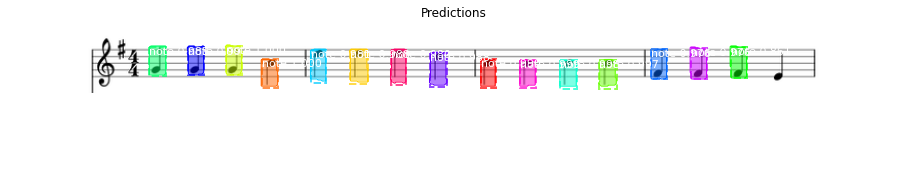

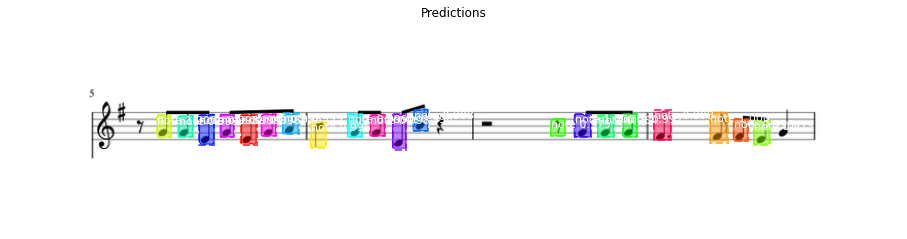

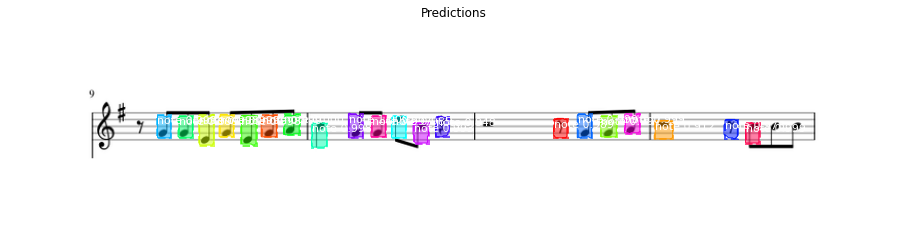

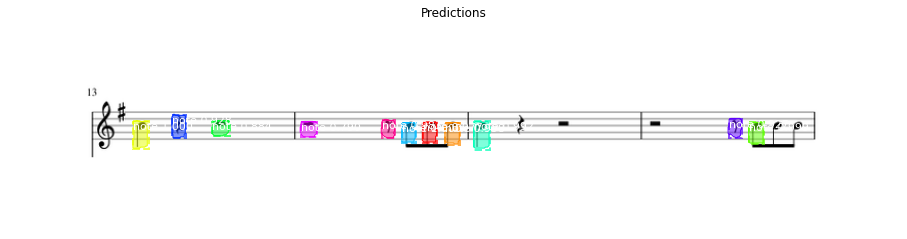

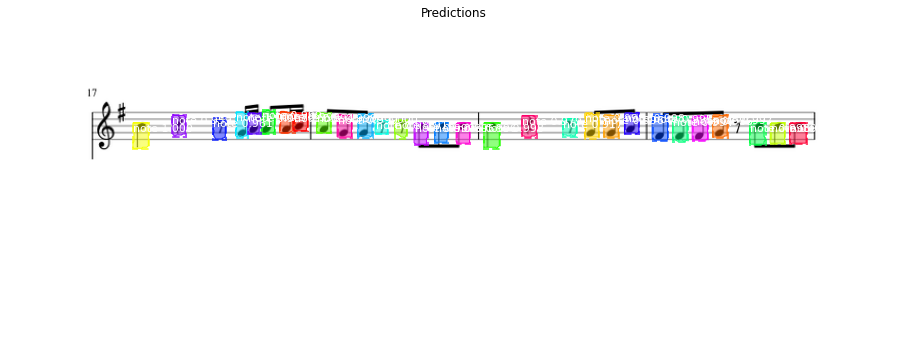

In [123]:
# Run object detection
totalResults = []
for im in noteRegions:
    results = modelNote.detect([im], verbose=1)

    # Display results
    ax = get_ax(1)
    r = results[0]
    totalResults.append(r)
    visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'], 
                                datasetNote.class_names, r['scores'], ax=ax,
                                title="Predictions")

In [124]:
sorted_totalResults = []
for i in range(len(totalResults)):
   
 
    bboxes = totalResults[i]['rois']
    sortedNotes = [a for a in range(len(bboxes))]

    for i,v in enumerate(sortedNotes):
        
        if i != len(sortedNotes)-1 and bboxes[sortedNotes[i]][1] > bboxes[sortedNotes[i+1]][1]:
            c = v
            sortedNotes[i] = sortedNotes[i+1]
            sortedNotes[i+1] = c


        k = i 
        while k >= 1:
            if bboxes[sortedNotes[k]][1] < bboxes[sortedNotes[k-1]][1]:
                c = sortedNotes[k]
                sortedNotes[k] = sortedNotes[k-1]
                sortedNotes[k-1] = c

            k -=1
    sorted_totalResults.append(sortedNotes)


        


In [125]:

allxH = []
allxR = []
allxM = []
ally = []
qi = 0

#image = cv2.imread(os.path.join(os.getcwd(),"dataNotev1/test/hpt.jpg"))

for i,result in enumerate(totalResults):
    if len(result['rois']) > 0:
        allxH.append([])
        allxR.append([])
        allxM.append([])
        ally.append([])
        for note in sorted_totalResults[i]:
            h = totalResults[i]['rois'][note][2] - totalResults[i]['rois'][note][0]
            w = totalResults[i]['rois'][note][3] - totalResults[i]['rois'][note][1]
            x =totalResults[i]['rois'][note][1]
            y = totalResults[i]['rois'][note][0]
            staffY = StaffBoxes[i][0]
            sh = int(StaffBoxes[i][2] - StaffBoxes[i][0])
            subh = int(sh/4)

            mask = np.zeros((subh,subh))
            for r in range(len(mask)):
                for c in range(len(mask)):
                    if (r - subh/2)**2 + (c - subh/2)**2 < subh*subh/4:
                        mask[r,c] = 1
            
            top = 0
            

            endm = noteRegions[i].shape[0]
            startm = 0
            
            for border in range(1, len(noteRegionStart)):
                if staffY < noteRegionStart[border]: 
                    startm = noteRegionStart[border-1]
                    endm = startm + 3*sh
                    #endm = noteRegionStart[border]
                    staffb = StaffBoxes[border -1]
                    break
                elif border == len(noteRegionStart)-1:
                    startm = noteRegionStart[border]
                    endm = startm + 3*sh
                    break
            
            
            startm = int(StaffBoxes[i][0] - sh/2)
            endm = int(StaffBoxes[i][0] + staffHeight[i] + sh/2)
            print(startm, endm)
            
            
            
            
            mask = []
            cmask =  copy.deepcopy(image[startm:endm,x:x+w,:])
            
            
           
            
            background = np.average(image[startm:endm,x:x+w,:]) + 255
            background /= 2
            #background = 255
            cmask[0:staffb[0]-startm, :,:] = background
            
            if y+h > staffY + sh - startm:
                cmask[y+h : , :,:] = background
            else:
                cmask[staffY+sh-startm : , :,:] = background
            
            
            bmask = np.zeros((cmask.shape[0],cmask.shape[1],3)) + 255
             
            bmask[int(staffY - startm):int(staffY+sh - startm),:,:] = 0
                    
            #mask.append(img[startm:endm,x:x+w,:])
            cmask[:staffY-startm-2,:,:] = background
            cmask[staffY+sh-startm+2:, :,:] = background
            
            
            """
            if y > staffY+sh - startm:
                cmask[:staffY-startm-2,:,:] = background
                cmask[staffY+sh-startm+2:, :,:] = background

                gooddata = True

                notem = np.zeros((h, w,3))
                hrw = h/w
                for nr in range(h):
                    for nc in range(w):
                        if (nr - h/2)**2 + (hrw)**2*(nc - w/2)**2 < h**2/4:
                            notem[nr, nc,:] = 1
                
                
                

                for mr, rv in enumerate(notem):
                    for mc,cv in enumerate(rv):
                       
                        if cv[0]== 0:
                            cmask[y+mr, mc,:] = 255
                        else:
                            cmask[y+mr, mc,:] = noteRegions[i][y+mr, mc,:]
            """
                

            
           
            cmask = cv2.resize(cmask, (20,100))
            bmask = cv2.resize(bmask, (20,100))
            mask.append(cmask)
            mask.append(bmask)
            

            allxM[qi].append(mask)
       
        allxM[qi] = np.array(allxM[qi])
        qi += 1
        
 

131 193
131 193
131 193
131 193
131 193
131 193
131 193
131 193
131 193
131 193
131 193
131 193
131 193
131 193
131 193
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
316 376
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
499 561
685 743
685 743
685 743
685 743
685 743
685 743
685 743
685 743
685 743
685 743
685 743
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930
870 930


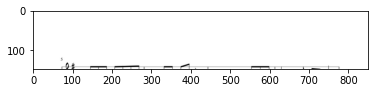

In [126]:
plt.imshow(image[190: 338, :, :])

In [149]:
allxM1 = []
allxM2 = []

def distribute(datas):
    allDis = []
    av = np.average(datas)
    for i, r in enumerate(datas):
        allDis.append([0,0,0])
        for c in r:
            if  0.299*c[0] + 0.587*c[1] + 0.114*c[2] < av:

                allDis[i][0] += 1
                allDis[i][1] += 1
                allDis[i][2] += 1
    
    allDis = np.array(allDis)/20
    return allDis

for u in range(len(allxM)):
    for i, v in enumerate(allxM[u]):
        allxM1.append(1 - np.rot90(cv2.resize(allxM[u][i][0], (20,100))/(255)))
        allxM2.append(distribute(allxM[u][i][0]))
    
    #allxM1[u] = np.array(allxM1[u])
    #allxM2[u] = np.array(allxM2[u])
    

allxM1 = np.array(allxM1)
allxM2 = np.array(allxM2)

print(allxM1.shape)
print(allxM2.shape)

(95, 20, 100, 3)
(95, 100, 3)


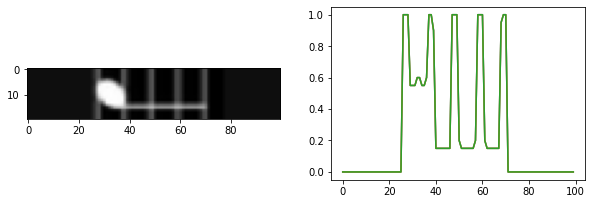

In [150]:
fig = plt.figure(figsize = (10,7))
n =4
fig.add_subplot(2,2,1)
plt.imshow(allxM1[n])

fig.add_subplot(2,2,2)
x = [i for i in range(len(allxM2[n]))]
plt.plot(x, allxM2[n])

In [151]:
import keras
from tensorflow.keras import activations
from tensorflow.keras import layers
c = ['G4','A4','B4','C3','D3','E3','F3','G3','A3','B3','C2','D2','E2','F2','G2','A2','B2','C','D','E','F','G']

class noteFocus(keras.layers.Layer):
    def __init__(self):
        super(noteFocus, self).__init__()
    
    def build(self, input_shape):
        self.space = np.zeros((100,3))
        for i in range(self.space.shape[0]):
            self.space[i][0] = i + 100
            self.space[i][1] = i + 100
            self.space[i][2] = i + 100
        self.space = self.space/200
        self.space = tf.convert_to_tensor(self.space, dtype = tf.float64)
        
        
    def get_w(self):
        return self.space
        
    def call(self, inputs):
        r = tf.math.multiply(self.space, tf.cast(inputs, dtype = tf.float64))
        r = tf.cast(r, dtype = tf.float32)
        return r




def conv_block(size, strike, input_tensor):
    x = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    
    shotcut = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    shotcut = keras.layers.Activation(activations.relu)(shotcut)

    x = keras.layers.Add()([x, shotcut])
    x = keras.layers.Activation(activations.relu)(x)
    
    return x

def identity_block(size, strike, input_tensor):
    x = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)

    x = keras.layers.Add()([x, input_tensor])
    x = keras.layers.Activation(activations.relu)(x)
    
    return x



#inputs = keras.layers.Input(shape = [100,20,3])

input_tensor = keras.layers.Input(shape = [20,100,3], name = "input")
distri_tensor = keras.layers.Input(shape = [100,3])


#distri_tensor = noteDistri()(input_tensor)
o = noteFocus()(distri_tensor)
#reshape = keras.layers.Reshape((20,100,3))(input_tensor)
#x = noteFocus()(reshape)
x = keras.layers.Multiply()([o, input_tensor])
x = keras.layers.Lambda(lambda x: 1-x)(x)

x = conv_block(64,1,x)
x = identity_block(64,1,x)

x = conv_block(64,3,x)
x = identity_block(64,3,x)
x = identity_block(64,3,x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

x = conv_block(128,3,x)
x = identity_block(128,3,x)
x = identity_block(128,3,x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

x = conv_block(256,3,x)
x = identity_block(256,3,x)
x = identity_block(256,3,x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
x = conv_block(512,3,x)
x = identity_block(512,3,x)
x = identity_block(512,3,x)
x = identity_block(512,3,x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

x = keras.layers.Flatten()(x)
#o = keras.layers.Dense(4096)(o)
a = keras.layers.Dense(4096, activation = 'relu')(x)
#a = keras.layers.Multiply()([o,a])

a = keras.layers.Dense(2048, activation = 'relu')(a)

a = keras.layers.Dense(1024, activation = 'relu')(a)
a = keras.layers.Dense(512, activation = 'relu')(a)
a = keras.layers.Dense(256, activation = 'relu')(a)
a = keras.layers.Dense(128, activation = 'relu')(a)
a = keras.layers.Dense(96, activation = 'relu')(a)      
a = keras.layers.Dense(48, activation = 'relu')(a)  
output = keras.layers.Dense(len(c), activation = "softmax")(a)


model  = keras.Model(inputs = [input_tensor, distri_tensor], outputs = [output])

with tf.device('/CPU:0'):
    model.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=['accuracy'])


In [152]:
model.load_weights("NoteClassificationv3.h5")

In [153]:
prediction = []
prediction.append(model.predict([allxM1, allxM2]))

#for i, y in enumerate(prediction):
#    for pred in range(len(y)):
#        prediction[i][pred] = round(prediction[i][pred])

In [154]:
maxv = []

for a,prey in enumerate(prediction):
    maxv.append([])
    for ipred in range(len(prey)):
        maxs = 0
        for i,index in enumerate(prey[ipred]):
            if index > prey[ipred][maxs]:
                maxs = i

        maxv[a].append(maxs-1)

print(maxv)


[[18, 6, 18, 8, 7, 7, 7, 10, 8, 8, 8, 8, 5, 5, 5, 17, 18, 2, 17, 3, 18, 7, 8, 17, 18, 5, 17, 14, 17, 18, 18, 5, 5, 5, 3, 18, 18, 4, 17, 2, 18, 7, 8, 17, 18, 10, 8, 9, 9, 17, 6, 7, 7, 9, 8, 8, 18, 7, 7, 7, 8, 8, 8, 8, 14, 8, 8, 18, 9, 6, 7, 7, 7, 18, 7, 6, 6, 7, 9, 8, 8, 8, 8, 9, 14, 6, 6, 7, 5, 5, 5, 6, 8, 8, 8]]


18


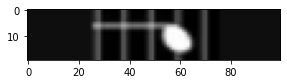

In [157]:
fig = plt.figure(figsize = (10,7))
n = 2
print(maxv[0][n])
fig.add_subplot(2,2,1)
plt.imshow(allxM1[n])

In [93]:
import pygame
pygame.mixer.init()
cl = ['G4','A4','B4','C3','D3','E3','F3','G3','A3','B3','C2','D2','E2','F2','G2','A2','B2','C','D','E','F','G']

pygame 2.1.2 (SDL 2.0.18, Python 3.6.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [145]:
import time
fig = plt.figure(figsize = (10,7))
for note in maxv:
    for n,i in enumerate(note):
        if i > 0 and i != 7:
            print(cl[i])
            pygame.mixer.music.load(os.path.join(os.getcwd(), f"dataset/pianoSoundSample/{cl[i]}.mp3"))
            pygame.mixer.music.play()
            time.sleep(1)

F3
F3
F3
A3
D2
D2
D2
C2
A3
A3
A3
A3
E3
E3
E3
F3
F3
D3
F3
D3
F3
C2
F3
F3
A4
B3
F3
F3
F3
E3
E3
E3
D3
F3
F3
D3
F3
D3
F3
A3
F3
F3
C2
A3
B3
B3
F3
F3
B3
B3
C2
C2
B3
B3
B3
B3
C2
C2
C2
C2
B3


KeyboardInterrupt: 

<Figure size 720x504 with 0 Axes>

In [25]:
               
                
    
    



allxH = []
allxR = []
allxM = []
ally = []
qi = 0
for i,result in enumerate(totalResults):
    if len(result['rois']) > 0:
        allxH.append([])
        allxR.append([])
        allxM.append([])
        ally.append([])
        for note in sorted_totalResults[i]:
            h = totalResults[i]['rois'][note][2] - totalResults[i]['rois'][note][0]
            w = totalResults[i]['rois'][note][3] - totalResults[i]['rois'][note][1]
            x =totalResults[i]['rois'][note][1]
            y = totalResults[i]['rois'][note][0]
            staffY = StaffBoxes[i][0]
            sh = int(StaffBoxes[i][2] - StaffBoxes[i][0])
            subh = int(sh/4)

            mask = np.zeros((subh,subh))
            for r in range(len(mask)):
                for c in range(len(mask)):
                    if (r - subh/2)**2 + (c - subh/2)**2 < subh*subh/4:
                        mask[r,c] = 1
            
            top = 0
        

            bwimage = cv2.cvtColor(noteRegions[i], cv2.COLOR_BGR2GRAY)
        
            tempy = y
            
            for yi in range(y,y+h-subh-1):
                for l,o in enumerate(bwimage[yi:yi+subh-1]):
                    for vx1 in range(x,x+w-subh-1):
                        temptop = 0
                        for z,j in enumerate(o[vx1:vx1+subh-1]):
                            if (mask[l][z]+1) * j < 2:
                                temptop += 1
                        if temptop > top:
                            top = temptop
                            tempy = yi + l
            
            y = tempy
            h = subh
            mask = np.zeros((noteRegions[i].shape[0],int(sh/4),3))
           
            mask[StaffBoxes[i][0] : StaffBoxes[i][2], :,:] = 150/255
            mask[y:int(y+sh/4), : ,:] = 1
            rate = (y+h-sh/8-staffY)/100
          

            endm = int(staffY+2*sh)
            startm = int(staffY-sh)
            if endm > (mask.shape[0]):
                endm = mask.shape[0]

            if startm < 0:
                startm = 0
            mask = mask[startm:endm, :,:]

            mask = cv2.resize(mask, (20,100))



            allxR[qi].append([rate])
            allxH[qi].append([sh/100])
            allxM[qi].append(mask)
        allxR[qi] = np.array(allxR[qi])
        allxH[qi] = np.array(allxH[qi])
        allxM[qi] = np.array(allxM[qi])
        qi += 1
        
                
                
    
    

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wbmte9m7\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


### Precision-Recall